## Artigo 1

A proposta desse arquivo é desenvolver uma técnica que permite maximizar a margem de um separador linear do tipo perceptron

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.spatial import Delaunay

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset(X, y, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[y==-1][:,0], X[y==-1][:,1], c='red', label="Classe 0")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c='blue', label="Classe 1")
    plt.title(title)
    plt.legend()
    plt.show()


def generate_separated_sines(n=200, x_min=0, x_max=4*np.pi, shift=1.5, noise_sigma=0.1, seed=0):
    """
    Gera duas curvas senoidais deslocadas verticalmente de forma que não se encostem.
    Retorna: X (2n x 2) com colunas [x, y], e y_labels (2n,) {0,1}.
    """
    rng = np.random.RandomState(seed)
    x = rng.uniform(x_min, x_max, size=n)
    x = np.sort(x)

    # Curvas deslocadas
    y_upper = np.sin(x) + shift + rng.normal(0, noise_sigma, size=n)
    y_lower = np.sin(x) - shift + rng.normal(0, noise_sigma, size=n)
    
    # Empilha em formato (x, y)
    X_upper = np.column_stack([x, y_upper])
    X_lower = np.column_stack([x, y_lower])
    
    X = np.vstack([X_upper, X_lower])
    labels = np.hstack([-1*np.ones(n), np.ones(n)])  # 1 = superior, 0 = inferior
    return X, labels


# 1. Distribuição em duas nuvens gaussianas
def gaussian_blobs(n=100):
    X0 = np.random.randn(n, 2) + np.array([-2, -2])
    X1 = np.random.randn(n, 2) + np.array([2, 2])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

# 2. Dados em duas faixas paralelas
def parallel_stripes(n=100):
    X0 = np.random.rand(n, 2) * 2 + np.array([0, 0])
    X1 = np.random.rand(n, 2) * 2 + np.array([3, 0])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

# 3. Dados separados por uma diagonal
def diagonal_split(n=200):
    X = np.random.uniform(-3, 3, size=(n, 2))
    y = (X[:,0] + X[:,1] > 0).astype(int)  # separação por reta diagonal
    return X, y

# 4. Duas classes em quadrados deslocados
def squares(n=100):
    X0 = np.random.rand(n, 2) + np.array([0, 0])
    X1 = np.random.rand(n, 2) + np.array([2, 2])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y




In [15]:
x, y = parallel_stripes()

In [16]:
def train_perceptron(X, y, lr=0.01, epochs=100, bias=True):
    if bias:
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # Adiciona o termo de bias como coluna
    # Inicializa pesos uniformemente entre -0.5 e 0.5
    weights = np.random.uniform(-0.5, 0.5, X.shape[1])
    for epoch in range(epochs):
        error = 0
        # Aleatoriza os índices
        indices = np.random.permutation(X.shape[0])
        for i in indices:
            # Calcula a ativação
            activation = np.dot(weights, X[i])
            # Atualiza os pesos se houver erro
            if y[i] * activation <= 0:
                weights += lr * y[i] * X[i]
                error += 1
        error_rate = error / X.shape[0]
        print(f'Epoch {epoch+1}/{epochs}, Error Rate: {error_rate:.4f}')
    return weights
        

Epoch 1/1, Error Rate: 0.1050


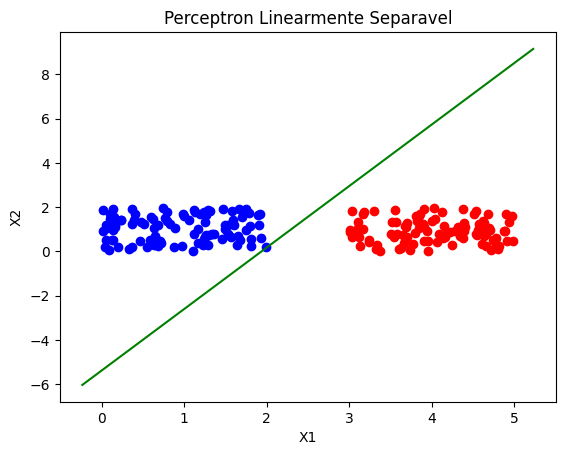

In [ ]:
pesos = train_perceptron(x,y,lr=0.1,epochs=10)
#Plota o separador linear sem meshgrid, só desenha a linha mesmo
plt.scatter(x[y==-1][:, 0], x[y==-1][:, 1], color="blue", label="Class 0")
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], color='red', label='Classe 1')
plt.xlabel('X1')    
plt.ylabel('X2')
plt.title('Perceptron Linearmente Separavel') 
x_vals = np.array(plt.gca().get_xlim())
y_vals = -(pesos[0] + pesos[1] * x_vals) / pesos[2]
plt.plot(x_vals, y_vals, color='green', label='Separador Linear')
plt.show()

## Construindo Grafo de Gabriel

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Circle


# -------------------------------------------------------------------------
# NOVA FUNÇÃO DE CONSTRUÇÃO POR FORÇA BRUTA
# -------------------------------------------------------------------------
def construct_gabriel_graph_brute_force(points: np.ndarray):
    """
    Constrói um Grafo de Gabriel usando o método de força bruta.

    Para cada par de pontos (u, v), ele verifica se algum outro ponto k
    se encontra dentro da circunferência cujo diâmetro é o segmento uv.

    Args:
        points (np.ndarray): Um array de formato (n_points, 2) com as coordenadas dos pontos.

    Returns:
        networkx.Graph: O Grafo de Gabriel.
    """
    num_points = points.shape[0]
    if num_points < 2:
        return nx.Graph()

    # Inicializa o grafo com todos os pontos como nós
    gabriel_graph = nx.Graph()
    gabriel_graph.add_nodes_from(range(num_points))

    # Tolerância (epsilon) para problemas de ponto flutuante
    epsilon = 1e-10

    # Loop 1: Itera sobre o primeiro ponto do par (u)
    for u in range(num_points):
        # Loop 2: Itera sobre o segundo ponto do par (v)
        # Começa de u + 1 para evitar pares duplicados (v, u) e auto-loops (u, u)
        for v in range(u + 1, num_points):
            p1 = points[u]
            p2 = points[v]

            # Calcular o ponto médio e o raio (ao quadrado) do círculo diametral
            midpoint = (p1 + p2) / 2
            radius_sq = np.sum((p1 - midpoint) ** 2)

            # Assume que a aresta é válida até que se prove o contrário
            is_gabriel_edge = True

            # Loop 3: Verifica todos os outros pontos (k)
            for k in range(num_points):
                if k == u or k == v:
                    continue  # Não verifica os pontos que formam a própria aresta

                pk = points[k]
                dist_sq = np.sum((pk - midpoint) ** 2)

                # Se um ponto está estritamente dentro do círculo, a aresta não é de Gabriel
                if dist_sq < radius_sq - epsilon:
                    is_gabriel_edge = False
                    break  # Encontrou um ponto dentro, não precisa verificar mais, quebra o loop 3

            # Se o loop 3 terminou sem encontrar nenhum ponto interno, a aresta é válida
            if is_gabriel_edge:
                gabriel_graph.add_edge(u, v)
                
    return gabriel_graph

# -------------------------------------------------------------------------
# A FUNÇÃO DE PLOTAGEM PERMANECE A MESMA
# -------------------------------------------------------------------------
def plot_graph(points: np.ndarray, labels: np.ndarray, gg: nx.Graph, title: str):
    """
    Plota os pontos, as arestas do Grafo de Gabriel e as circunferências
    diametrais para arestas que conectam classes diferentes.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Desenhar as circunferências de Gabriel para arestas entre classes opostas
    for u, v in gg.edges():
        if labels[u] != labels[v]:
            p1 = points[u]
            p2 = points[v]
            center = (p1 + p2) / 2
            radius = np.linalg.norm(p1 - center)
            circle = Circle(center, radius, fill=False, color='gray', linestyle='--', linewidth=1, alpha=0.9, zorder=0)
            ax.add_patch(circle)

    # Plotar as arestas
    for u, v in gg.edges():
        p1 = points[u]
        p2 = points[v]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', alpha=0.6, linewidth=1.2, zorder=1)

    # Plotar os vértices
    scatter = ax.scatter(points[:, 0], points[:, 1], c=labels, s=100, cmap='viridis', edgecolor='k', zorder=2)
    legend1 = ax.legend(*scatter.legend_elements(), title="Categorias")
    ax.add_artist(legend1)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Coordenada X", fontsize=12)
    ax.set_ylabel("Coordenada Y", fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()


    # --- Construção e Plotagem ---
    print("Construindo o Grafo de Gabriel via FORÇA BRUTA (pode demorar)...")
    
    # ATENÇÃO: Chamando a nova função de força bruta
   
    
  



In [19]:
print("Construindo o Grafo de Gabriel via FORÇA BRUTA (pode demorar)...")
gabriel_graph = construct_gabriel_graph_brute_force(x)

Construindo o Grafo de Gabriel via FORÇA BRUTA (pode demorar)...


Grafo construído com 200 nós e 368 arestas.


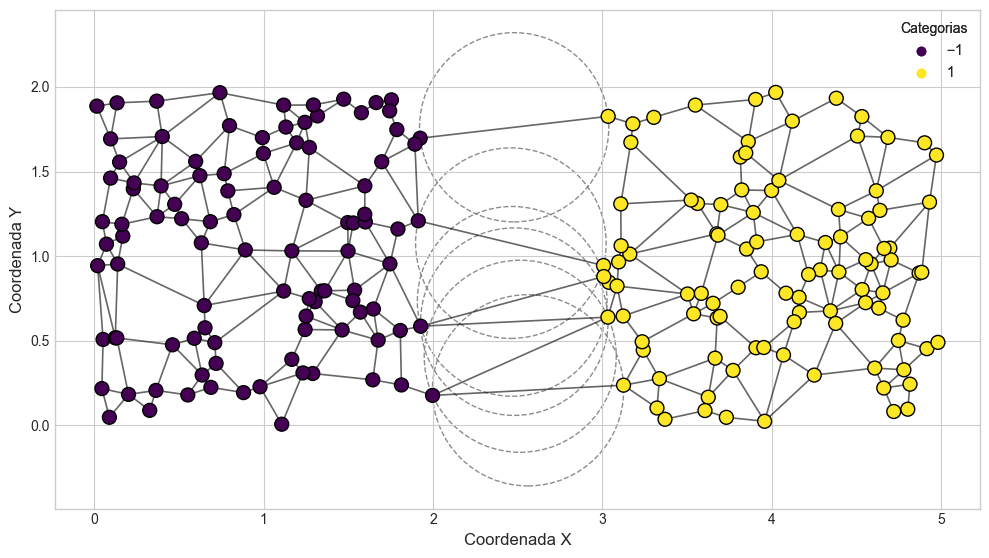

Construindo o Grafo de Gabriel via FORÇA BRUTA (pode demorar)...


In [20]:
print(f"Grafo construído com {gabriel_graph.number_of_nodes()} nós e {gabriel_graph.number_of_edges()} arestas.")  
plot_graph(x,y,gabriel_graph,title="")